## Introducción

En este apartado vamos a ver una introducción a cómo hacer ajustes e interpolaciones en Python utilizando NumPy y los módulos *interpolate* y *optimize* de SciPy.

**Ajustes de curvas** e **interpolaciones** son dos tareas básicas que realizaremos con mucha frecuencia. Por ejemplo, cuando recojamos los datos de un experimento: sabemos que se tienen que comportar como una parábola, pero obviamente por errores de medición u otro tipo no obtenemos una parábola exactamente. En este caso necesitaremos realizar un ajuste de los datos, conocido el modelo (una curva de segundo grado en este caso).

En otras ocasiones dispondremos de una serie de puntos y querremos construir una curva que pase por todos ellos. En este caso lo que queremos es realizar una interpolación: si tenemos pocos puntos podremos usar un polinomio, y en caso contrario habrá que usar trazadores (splines en inglés). Vamos a empezar por este último método.

In [1]:
%matplotlib inline

## Interpolación

Lo primero que vamos a hacer va a ser desterrar la idea de que, sea cual sea el número de puntos que tengamos, podemos construir un polinomio que pase por todos ellos «y que lo haga bien». Si tenemos N puntos nuestro polinomio tendrá que ser de grado menor o igual que N−1, pero cuando N

empieza a ser grande (del orden de 10 o más) a menos que los puntos estén muy cuidadosamente elegidos el polinomio oscilará salvajemente. Esto se conoce como fenómeno de Runge.

Para ver esto podemos estudiar el clásico ejemplo que dio Runge: tenemos la función

$\displaystyle f(x) = \frac{1}{1 + x^2}$

veamos qué sucede si la interpolamos en nodos equiespaciados. Para ello vamos a usar la función barycentric_interpolate (según Berrut y Trefethen [II] «[El método de interpolación baricéntrica] merece ser conocido como el método estándar de interpolación polinómica»). Esta función recibe tres argumentos:

    • una lista de coordenadas x_i de los nodos,
    • una lista de coordenadas y_i de los nodos, y
    • un array x donde evaluar el polinomio interpolante que resulta.

El código será este:

In [2]:
from scipy import interpolate

In [3]:
import numpy as np
from scipy.interpolate import barycentric_interpolate

def runge(x):
    """Función de Runge."""
    return 1 / (1 + x ** 2)

N = 11  # Nodos de interpolación

xp = np.arange(11) - 5  # -5, -4, -3, ..., 3, 4, 5
fp = runge(xp)

x = np.linspace(-5, 5, num=1000)

y = barycentric_interpolate(xp, fp, x)

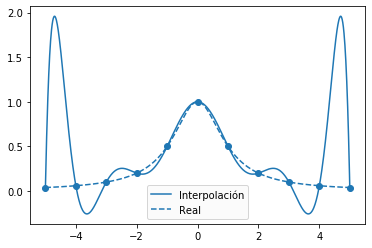

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt

l, = plt.plot(x, y)
plt.plot(x, runge(x), '--', c=l.get_color())
plt.plot(xp, fp, 'o', c=l.get_color())
leg = plt.legend(['Interpolación', 'Real'])
leg.get_frame().set_facecolor('#fafafa')

Existe una forma de mitigar este problema, que es, como ya hemos dicho, «escogiendo los puntos cuidadosamente». Una de las formas es elegir las raíces de los polinomios de Chebyshev, que podemos construir en NumPy usando el módulo polynomial.chebyshev. Por ejemplo, si queremos como antes 11 nodos tendremos que escoger el polinomio de Chebyshev de grado 11:

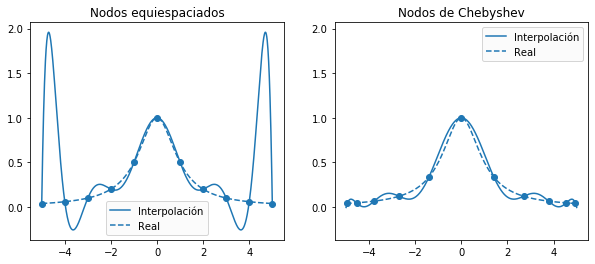

In [5]:
from numpy.polynomial import chebyshev

coeffs_cheb = [0] * 11 + [1]
T11 = chebyshev.Chebyshev(coeffs_cheb, [-5, 5])

xp_ch = T11.roots()
fp_ch = runge(xp_ch)

y_ch = barycentric_interpolate(xp_ch, fp_ch, x)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

l1, = ax1.plot(x, y)
ax1.plot(x, runge(x), '--', c=l1.get_color())
ax1.plot(xp, fp, 'o', c=l1.get_color())
ax1.set_title("Nodos equiespaciados")

leg1 = ax1.legend(['Interpolación', 'Real'])
leg1.get_frame().set_facecolor('#fafafa')

l2, = ax2.plot(x, y_ch)
ax2.plot(x, runge(x), '--', c=l2.get_color())
ax2.plot(xp_ch, fp_ch, 'o', c=l2.get_color())
ax2.set_ylim(ax1.get_ylim())
ax2.set_title("Nodos de Chebyshev")

leg2 = ax2.legend(['Interpolación', 'Real'])
leg2.get_frame().set_facecolor('#fafafa')

Aun así, aún tenemos varios problemas:

    • El polinomio sigue oscilando, y esto puede no ser deseable.
    • No siempre podemos escoger los puntos como nosotros queramos.

Por tanto, desde ya vamos a abandonar la idea de usar polinomios y vamos a hablar de trazadores (splines en inglés).

### Trazadores

Los trazadores o splines no son más que curvas polinómicas definidas a trozos, normalmente de grado 3 (casi nunca mayor de 5). Al ser cada uno de los trozos de grado pequeño se evita el fenómeno de Runge, y si se «empalman» los trozos inteligentemente la curva resultante será suave (matemáticamente: diferenciable) hasta cierto punto. Cuando queremos una curva que pase por todos los puntos disponibles un trazador es justamente lo que necesitamos.

El trazador más elemental, el lineal (grado 1), se puede construir rápidamente en NumPy usando np.interp. El más común, el trazador cúbico (grado 3) se puede construir con la clase scipy.interpolate.InterpolatedUnivariateSpline. Si pasamos a esta clase un argumento k podemos especificar el grado del trazador (entre 1 y 5).

Número de puntos: 21


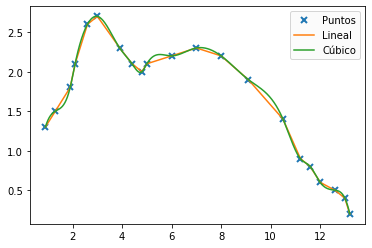

In [6]:
from scipy.interpolate import InterpolatedUnivariateSpline

puntos = [(0.9, 1.3), (1.3, 1.5), (1.9, 1.8), (2.1,2.1), (2.6, 2.6), (3.0, 2.7),
     (3.9, 2.3), (4.4, 2.1), (4.8, 2.0), (5.0, 2.1), (6, 2.2), (7, 2.3),
     (8, 2.2), (9.1, 1.9), (10.5, 1.4), (11.2, 0.9), (11.6, 0.8), (12, 0.6),
     (12.6, 0.5), (13, 0.4), (13.2, 0.2)]
xi, yi = zip(*puntos)

print("Número de puntos: {}".format(len(xi)))

x = np.linspace(min(xi), max(xi), num=1001)

y1d = InterpolatedUnivariateSpline(xi, yi, k=1)(x)
ysp = InterpolatedUnivariateSpline(xi, yi, k=3)(x)

plt.plot(xi, yi, 'x', mew=2)
plt.plot(x, y1d)
plt.plot(x, ysp)
leg = plt.legend(['Puntos', 'Lineal', 'Cúbico'])
leg.get_frame().set_facecolor('#fafafa')

En ocasiones, sin embargo, puede que no necesitemos un trazador que pase por todos los puntos, sino una curva o un modelo más sencillo que aproxime una serie de puntos, tratando de cometer el mínimo error posible.

## Ajuste de curvas

En ocasiones las cosas son más complicadas que un polinomio. Pero no pasa nada, porque con la función scipy.optimize.curve_fit podemos ajustar una serie de datos a cualquier modelo que se nos ocurra, no importa qué tan complicado sea. Sin ir más lejos, tomando el ejemplo de la documentación, supongamos que tenemos unos datos que se ajustan al modelo.

$$y = A e^{-B x^2} + C$$

en Python nuestro modelo será una función que recibirá como primer argumento x y el resto serán los parámetros del mismo:

In [7]:
def func(x, A, B, C):
    """Modelo para nuestros datos."""
    return A * np.exp(-B * x ** 2) + C

Ahora solo necesitamos algunos datos (añadiremos un poco de ruido gaussiano para que tenga más gracia) y podemos probar el ajuste. La función scipy.optimize.curve_fit recibe como argumentos:

    • el modelo func para los datos,
    • una lista de coordenadas xdata de los puntos, y
    • una lista de coordenadas ydata de los puntos.

Así realizamos el ajuste:

In [8]:
from scipy.optimize import curve_fit

Adat, Bdat, Cdat = 2.5, 1.3, 0.5

xdat = np.linspace(-2, 4, 12)
ydat = func(xdat, Adat, Bdat, Cdat) + 0.2 * np.random.normal(size=len(xdat))

(A, B, C), _ = curve_fit(func, xdat, ydat)
print(A, B, C)

2.774232850952435 1.3497244017610175 0.37940489665495597


In [9]:
curve_fit(func, xdat, ydat)

(array([2.77423285, 1.3497244 , 0.3794049 ]),
 array([[ 0.03355403,  0.01325936, -0.00464752],
        [ 0.01325936,  0.05064731,  0.0090297 ],
        [-0.00464752,  0.0090297 ,  0.006568  ]]))

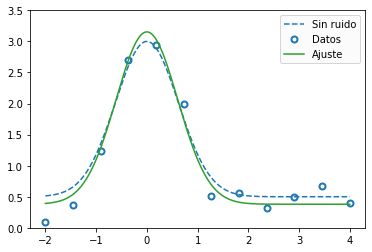

In [10]:
x = np.linspace(-2, 4, 1001)

l, = plt.plot(x, func(x, Adat, Bdat, Cdat), '--', label="Sin ruido")
plt.plot(xdat, ydat, 'o', mew=2, mfc="none", mec=l.get_color(), label="Datos")
plt.plot(x, func(x, A, B, C), label="Ajuste")
plt.ylim(0, 3.5)
leg = plt.legend()
leg.get_frame().set_facecolor('#fafafa')
